# Fine-tuning BERT (and friends) for multi-label text classification

In this notebook, we are going to fine-tune BERT to predict one or more labels for a given piece of text. Note that this notebook illustrates how to fine-tune a bert-base-uncased model, but you can also fine-tune a RoBERTa, DeBERTa, DistilBERT, CANINE, ... checkpoint in the same way.

All of those work in the same way: they add a linear layer on top of the base model, which is used to produce a tensor of shape (batch_size, num_labels), indicating the unnormalized scores for a number of labels for every example in the batch.



## Set-up environment

First, we install the libraries which we'll use: HuggingFace Transformers and Datasets.

In [1]:
! pip install datasets
! pip install -U accelerate
! pip install -U transformers

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [2]:
! pip install --upgrade tqdm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 78 kB 1.7 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ru-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 which is incompatible.
ro-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 which is incompatible.
ko-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 which is incompatible.
it-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 which is incompatible.
fr-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 which is incompatible.
es-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 which is incompatible.
de-core-news-lg 3.7.0 requires spacy<3.8.0,>=3.7.0, but you have spacy 3.4.4 whi

In [3]:
!pip install evaluate

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
import numpy as np
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)
from transformers import (
  AutoTokenizer,
  AutoModelForSequenceClassification,
  Trainer,
  TrainingArguments,
  DataCollatorWithPadding
)
from huggingface_hub import HfFolder, notebook_login
from datasets import Dataset
from matplotlib import pyplot as plt
import seaborn as sns
import evaluate


## Load dataset

Next, let's download a multi-label text classification dataset from the [hub](https://huggingface.co/).

At the time of writing, I picked a random one as follows:   

* first, go to the "datasets" tab on huggingface.co
* next, select the "multi-label-classification" tag on the left as well as the the "1k<10k" tag (fo find a relatively small dataset).

Note that you can also easily load your local data (i.e. csv files, txt files, Parquet files, JSON, ...) as explained [here](https://huggingface.co/docs/datasets/loading.html#local-and-remote-files).



In [2]:
df = pd.read_csv('data/all_data.csv')
df

,Text,Country,Source,Label
0,Palaeontologist.,uk,real,0
1,\n> We have the capability of being better. B...,uk,real,1
2,"Only just noticed it myself, ha! Or Ha, accord...",uk,real,0
3,Mate all he does is play football and misses p...,uk,real,1
4,"Me neither. But then, I'm not sure Cleese woul...",uk,real,0
...,...,...,...,...
5995,"Often, I find my inspiration in the diverse an...",india,generated,1
5996,I often find inspiration in people overcoming ...,india,generated,1
5997,What inspires me most is the sheer determinati...,india,generated,1
5998,"Just the other day, I watched a fascinating do...",india,generated,1


In [3]:
df['UK'] = df['Country'] == 'uk'
df['India'] = df['Country'] == 'india'
df['Real'] = df['Source'] == 'real'
df['Generated'] = df['Source'] == 'generated'
df['Inspirational'] = df['Label'] == 1
df['Non-Inspirational'] = df['Label'] == 0

In [4]:
df = df[['Text', 'UK', 'India', 'Real', 'Generated', 'Inspirational', 'Non-Inspirational']]

In [5]:
df

,Text,UK,India,Real,Generated,Inspirational,Non-Inspirational
0,Palaeontologist.,True,False,True,False,False,True
1,\n> We have the capability of being better. B...,True,False,True,False,True,False
2,"Only just noticed it myself, ha! Or Ha, accord...",True,False,True,False,False,True
3,Mate all he does is play football and misses p...,True,False,True,False,True,False
4,"Me neither. But then, I'm not sure Cleese woul...",True,False,True,False,False,True
...,...,...,...,...,...,...,...
5995,"Often, I find my inspiration in the diverse an...",False,True,False,True,True,False
5996,I often find inspiration in people overcoming ...,False,True,False,True,True,False
5997,What inspires me most is the sheer determinati...,False,True,False,True,True,False
5998,"Just the other day, I watched a fascinating do...",False,True,False,True,True,False


In [6]:
print('Null values: ', df.isnull().values.any())
df = df.dropna()
print('Null values: ', df.isnull().values.any())

Null values:  True
Null values:  False


In [7]:
df['Text'] = df['Text'].astype(str)

/tmp/ipykernel_165751/3500421930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Text'] = df['Text'].astype(str)


In [8]:
df = df[df['Text'].str.strip() != '']

In [9]:
# Split the DataFrame into train, validation, and test sets
# Defaul split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.2, random_state=42, shuffle=True)

# # Few shot split
# train_df, temp_df = train_test_split(df, test_size=0.9, random_state=42, shuffle=True)
# val_df, test_df = train_test_split(temp_df, test_size=0.9, random_state=42, shuffle=True)

# Reset index
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Create Dataset objects
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Text', 'UK', 'India', 'Real', 'Generated', 'Inspirational', 'Non-Inspirational'],
        num_rows: 4799
    })
    validation: Dataset({
        features: ['Text', 'UK', 'India', 'Real', 'Generated', 'Inspirational', 'Non-Inspirational'],
        num_rows: 960
    })
    test: Dataset({
        features: ['Text', 'UK', 'India', 'Real', 'Generated', 'Inspirational', 'Non-Inspirational'],
        num_rows: 240
    })
})

In [11]:
labels = [label for label in dataset['train'].features.keys() if label not in ['Text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['UK', 'India', 'Real', 'Generated', 'Inspirational', 'Non-Inspirational']

## Preprocess data

As models like BERT don't expect text as direct input, but rather `input_ids`, etc., we tokenize the text using the tokenizer. Here I'm using the `AutoTokenizer` API, which will automatically load the appropriate tokenizer based on the checkpoint on the hub.

What's a bit tricky is that we also need to provide labels to the model. For multi-label text classification, this is a matrix of shape (batch_size, num_labels). Also important: this should be a tensor of floats rather than integers, otherwise PyTorch' `BCEWithLogitsLoss` (which the model will use) will complain, as explained [here](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3).

In [12]:
model_id = "FacebookAI/xlm-roberta-base"

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [14]:
def preprocess_data(examples):
  # take a batch of texts
  text = examples["Text"]
  # encode them
  encoding = tokenizer(text, padding=True, truncation=True, max_length=256)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]
  encoding["labels"] = labels_matrix.tolist()
  return encoding

In [15]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/4799 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

In [16]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


In [17]:
tokenizer.decode(example['input_ids'])

"<s> In this challenging world, it's the strength and resilience of everyday individuals in India that truly inspire me. Seeing people embrace the daily struggles, yet maintaining their smiles, fighting all odds and emerging triumphantly; these are the stories that keep me motivated. Cheers to the human spirit! Never underestimate the power of hope and determination.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><p

In [18]:
example['labels']

[0.0, 1.0, 0.0, 1.0, 1.0, 0.0]

In [19]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['India', 'Generated', 'Inspirational']

Finally, we set the format of our data to PyTorch tensors. This will turn the training, validation and test sets into standard PyTorch [datasets](https://pytorch.org/docs/stable/data.html).

In [20]:
encoded_dataset.set_format("torch")

## Define model

Here we define a model that includes a pre-trained base (i.e. the weights from bert-base-uncased) are loaded, with a random initialized classification head (linear layer) on top. One should fine-tune this head, together with the pre-trained base on a labeled dataset.

This is also printed by the warning.

We set the `problem_type` to be "multi_label_classification", as this will make sure the appropriate loss function is used (namely [`BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)). We also make sure the output layer has `len(labels)` output neurons, and we set the id2label and label2id mappings.

In [21]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train the model!

We are going to train the model using HuggingFace's Trainer API. This requires us to define 2 things:

* `TrainingArguments`, which specify training hyperparameters. All options can be found in the [docs](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments). Below, we for example specify that we want to evaluate after every epoch of training, we would like to save the model every epoch, we set the learning rate, the batch size to use for training/evaluation, how many epochs to train for, and so on.
* a `Trainer` object (docs can be found [here](https://huggingface.co/transformers/main_classes/trainer.html#id1)).

In [22]:
batch_size = 8
num_train_epochs = 5
metric_name = "f1"

In [23]:
from transformers import TrainingArguments, Trainer

In [24]:
args = TrainingArguments(
    f"reecursion/roberta-finetuned-inspirational",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We are also going to compute metrics while training. For this, we need to define a `compute_metrics` function, that returns a dictionary with the desired metric values.

In [25]:
from sklearn.metrics import classification_report

label_names = ['UK', 'India', 'Real', 'Generated', 'Inspirational', 'Non-Inspirational']

In [26]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    clf_report = classification_report(y_true, y_pred, target_names=label_names, digits=3, output_dict=True)
    print(clf_report)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result

Let's verify a batch as well as a forward pass:

In [27]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [28]:
encoded_dataset['train']['input_ids'][0]

tensor([     0,    360,    903, 223920,   8999,      4,    442,     25,      7,
            70,  90254,    136,   3332,   2104,   6620,    111, 190704,  79165,
            23,   5596,    450,  87607,  16877,     13,    163,      5,   6872,
           214,   3395,     28,  12846,    329,     70,  31815, 151994,      7,
             4,  14373,  76104,    214,   2363,  49488,      7,      4, 181952,
           756, 103044,    136,  50419,   9966, 231296,   1236,    538,     74,
          6097,    621,     70,  43515,    450,  13695,    163, 167729,    297,
             5,   5024,   1314,     47,     70,  14135,  52101,     38,  89726,
          1379,  72992,     67,     70,  14537,    111,  15673,    136,  27354,
          1363,      5,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [29]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


SequenceClassifierOutput(loss=tensor(0.6421, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.2605,  0.0786,  0.2128, -0.1368,  0.2710, -0.4558]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

Let's start training!

In [30]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/home/oignat/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.305000,0.201673,0.913164,0.913194,0.748958
2,0.146500,0.147387,0.947405,0.947396,0.847917
3,0.088000,0.140641,0.957292,0.957292,0.882292
4,0.058500,0.126463,0.965793,0.965799,0.904167
5,0.024900,0.134681,0.967350,0.967361,0.907292


{'UK': {'precision': 0.9457142857142857, 'recall': 0.6741344195519349, 'f1-score': 0.7871581450653983, 'support': 491}, 'India': {'precision': 0.7368421052631579, 'recall': 0.9552238805970149, 'f1-score': 0.8319405756731663, 'support': 469}, 'Real': {'precision': 1.0, 'recall': 0.9798136645962733, 'f1-score': 0.9898039215686275, 'support': 644}, 'Generated': {'precision': 0.9604863221884499, 'recall': 1.0, 'f1-score': 0.9798449612403101, 'support': 316}, 'Inspirational': {'precision': 0.9385307346326837, 'recall': 0.9750778816199377, 'f1-score': 0.9564553093964858, 'support': 642}, 'Non-Inspirational': {'precision': 0.9453924914675768, 'recall': 0.8710691823899371, 'f1-score': 0.90671031096563, 'support': 318}, 'micro avg': {'precision': 0.9134815844336345, 'recall': 0.9128472222222223, 'f1-score': 0.9131642931573463, 'support': 2880}, 'macro avg': {'precision': 0.9211609898776923, 'recall': 0.9092198381258497, 'f1-score': 0.9086522039849362, 'support': 2880}, 'weighted avg': {'precisi

TrainOutput(global_step=3000, training_loss=0.11016682942708333, metrics={'train_runtime': 553.3883, 'train_samples_per_second': 43.36, 'train_steps_per_second': 5.421, 'total_flos': 3156788256721920.0, 'train_loss': 0.11016682942708333, 'epoch': 5.0})

## Evaluate

After training, we evaluate our model on the validation set.

In [32]:
# trainer.evaluate()
trainer.evaluate(eval_dataset=encoded_dataset["test"]) # evaluate on test

{'UK': {'precision': 0.9576271186440678, 'recall': 0.9338842975206612, 'f1-score': 0.9456066945606695, 'support': 121}, 'India': {'precision': 0.9344262295081968, 'recall': 0.957983193277311, 'f1-score': 0.9460580912863071, 'support': 119}, 'Real': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 162}, 'Generated': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 78}, 'Inspirational': {'precision': 0.9625, 'recall': 0.9565217391304348, 'f1-score': 0.9595015576323987, 'support': 161}, 'Non-Inspirational': {'precision': 0.9125, 'recall': 0.9240506329113924, 'f1-score': 0.9182389937106918, 'support': 79}, 'micro avg': {'precision': 0.9638888888888889, 'recall': 0.9638888888888889, 'f1-score': 0.9638888888888889, 'support': 720}, 'macro avg': {'precision': 0.9611755580253774, 'recall': 0.9620733104733, 'f1-score': 0.9615675561983444, 'support': 720}, 'weighted avg': {'precision': 0.9640550037047327, 'recall': 0.9638888888888889, 'f1-score': 0.9639166030373227, 'su

{'eval_loss': 0.14738111197948456,
 'eval_f1': 0.9638888888888889,
 'eval_roc_auc': 0.963888888888889,
 'eval_accuracy': 0.8916666666666667,
 'eval_runtime': 1.2042,
 'eval_samples_per_second': 199.301,
 'eval_steps_per_second': 24.913,
 'epoch': 5.0}

In [69]:
import shutil
torch.cuda.empty_cache()
shutil.rmtree('reecursion/roberta-finetuned-inspirational') # CHECKPOINTS might mess when trying to re-train

FileNotFoundError: [Errno 2] No such file or directory: 'reecursion/roberta-finetuned-inspirational'

In [ ]:
notebook_login()

In [ ]:
repository_id = 'reecursion/roberta-finetuned-inspirational'

In [ ]:
# Save our tokenizer and create a model card
model.save_pretrained(repository_id)
tokenizer.save_pretrained(repository_id)
trainer.create_model_card()
# Push the results to the hub
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

events.out.tfevents.1712813866.a71397fe554d.171.2:   0%|          | 0.00/8.67k [00:00<?, ?B/s]

events.out.tfevents.1712815401.a71397fe554d.171.3:   0%|          | 0.00/508 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/reecursion/roberta-finetuned-inspirational/commit/feb25227ae1a1196280450c6064aa0289a7d3488', commit_message='End of training', commit_description='', oid='feb25227ae1a1196280450c6064aa0289a7d3488', pr_url=None, pr_revision=None, pr_num=None)

## Inference

In [ ]:
text = "sample text"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

The logits that come out of the model are of shape (batch_size, num_labels). As we are only forwarding a single sentence through the model, the `batch_size` equals 1. The logits is a tensor that contains the (unnormalized) scores for every individual label.

In [ ]:
logits = outputs.logits
logits.shape

torch.Size([1, 4])

In [ ]:
logits

tensor([[-3.9328,  4.0487,  8.0196, -6.3656]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

To turn them into actual predicted labels, we first apply a sigmoid function independently to every score, such that every score is turned into a number between 0 and 1, that can be interpreted as a "probability" for how certain the model is that a given class belongs to the input text.

Next, we use a threshold (typically, 0.5) to turn every probability into either a 1 (which means, we predict the label for the given example) or a 0 (which means, we don't predict the label for the given example).

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['India', 'Real']


### Visualize results

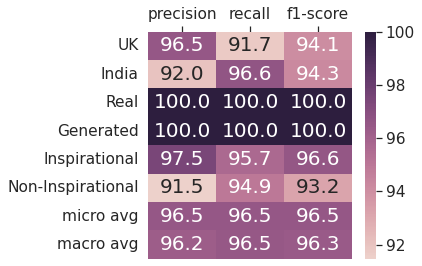

In [35]:
import matplotlib.pyplot as plt

# #default
clf_report = {'UK': {'precision': 0.9652173913043478 * 100, 'recall': 0.9173553719008265* 100, 'f1-score': 0.940677966101695* 100, 'support': 121}, 
 'India': {'precision': 0.92* 100, 'recall': 0.9663865546218487* 100, 'f1-score': 0.9426229508196722* 100, 'support': 119}, 
 'Real': {'precision': 1.0* 100, 'recall': 1.0* 100, 'f1-score': 1.0* 100, 'support': 162}, 
 'Generated': {'precision': 1.0* 100, 'recall': 1.0* 100, 'f1-score': 1.0* 100, 'support': 78}, 
 'Inspirational': {'precision': 0.9746835443037974* 100, 'recall': 0.9565217391304348* 100, 'f1-score': 0.9655172413793103* 100, 'support': 161}, 
 'Non-Inspirational': {'precision': 0.9146341463414634* 100, 'recall': 0.9493670886075949* 100, 'f1-score': 0.9316770186335404* 100, 'support': 79}, 
 'micro avg': {'precision': 0.9652777777777778* 100, 'recall': 0.9652777777777778* 100, 'f1-score': 0.9652777777777778* 100, 'support': 720}, 
 'macro avg': {'precision': 0.9624225136582681* 100, 'recall': 0.9649384590434508* 100, 'f1-score': 0.9634158628223696* 100, 'support': 720}
}

# #few-shot
clf_report = {'UK': {'precision': 0.8424474187380497*100, 'recall': 0.9043513957307061*100, 'f1-score': 0.8723025143535934*100, 'support': 2436},
'India': {'precision': 0.8928571428571429*100, 'recall': 0.8353960396039604*100, 'f1-score': 0.8631713554987213*100, 'support': 2424}, 
'Real': {'precision': 0.9962417788913248*100, 'recall': 0.9778665846910544*100, 'f1-score': 0.9869686627365809*100, 'support': 3253}, 
'Generated': {'precision': 0.9449052132701422*100, 'recall': 0.9925326695706285*100, 'f1-score': 0.968133535660091*100, 'support': 1607}, 
'Inspirational': {'precision': 0.9051932367149759*100, 'recall': 0.9244526672833796*100, 'f1-score': 0.9147215865751335*100, 'support': 3243}, 
'Non-Inspirational': {'precision': 0.8414322250639387*100, 'recall': 0.8138528138528138*100, 'f1-score': 0.8274127632819868*100, 'support': 1617}, 
'micro avg': {'precision': 0.9096994535519126*100, 'recall': 0.9134430727023319*100, 'f1-score': 0.9115674195756333*100, 'support': 14580}, 
'macro avg': {'precision': 0.903846169255929*100, 'recall': 0.908075361788757*100, 'f1-score': 0.9054517363510178*100, 'support': 14580}
}

sns.set(font_scale=1.4)
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, fmt=".1f", annot_kws={"size": 20},
                 cmap=sns.cubehelix_palette(as_cmap=True))
ax.xaxis.tick_top()

plt.tight_layout()
plt.savefig('data/default.png', bbox_inches='tight')
# plt.savefig('data/fewshot.png', bbox_inches='tight')